# COGS 108 - EDA Checkpoint

# Names

- Khulan Hoshartsaga
- Fione Huynh
- Lara Pellon
- Ezhil Thaenraj
- Rafael Ubriaco

<a id='research_question'></a>
# Research Question

How has COVID-19 impacted high-income counties air quality in comparison to middle-income and low-income counties?

# Dataset(s)

Dataset Name: County GDP Capita 2009-2018

Link to the dataset: https://ssti.org/blog/useful-stats-capita-county-level-gdp

Number of observations: 3116 (before data cleaning)

Columns in the dataset for each observation:
- State
- County
- GDP Per Capita 2018

Description: This dataset is from the State Science & Technology Institute site from a national nonprofit organization. It contains the gross domestic product (GDP) per capita for all of the counties and states in the United States from 2009 to 2018. It also includes information about each counties' rankings in their state and the percent change during those years.



Dataset Name: Daily AQI By County 2018-2020

Link to the dataset: https://aqs.epa.gov/aqsweb/documents/data_api.html

Number of observations: 903067 (before data cleaning)

Columns in the dataset for each observation:
- State Name
- County Name
- State Code
- County Code
- Date
- AQI
- Category
- Defining Parameter
- Defining Site
- Number of Sites Reporting

Description: This dataset is from the United States Enviromental Protection Agency. This dataset has the daily AQI for all of the counties in the United States from 2018 to 2020. (We split the data into the seperate years, but all of the data on AQI is from this one dataset). It also contains information specific to how the data was gathered like the number of sites and the code for the defining site.

How we plan to combine our datasets: We are using the first dataset on GDP to determine which county is consider affluent. Then we are using the the second dataset to see the changes in air quality before and after COVID-19. 


# Setup

In [1]:
import pandas as pd
from datetime import datetime
import seaborn as sns
import numpy as np
!pip install xlrd
!pip install openpyxl

     |████████████████████████████████| 96 kB 9.7 MB/s 
     |████████████████████████████████| 243 kB 15.9 MB/s 


In [2]:
# read in the data

gdp_data = pd.read_excel('beareal-county-gdp-capita-2009-2018.xlsx', engine='openpyxl')
aqi_data = pd.read_csv('AQI.csv')

# Data Cleaning

### GDP Data Cleaning

Since there are an excess amount of columns that we would not like to use, we dropped every column except for <mark>State</mark>, <mark>County</mark>, and <mark>GDP per Capita 2018</mark>.

In [3]:
gdp_data.drop(gdp_data.columns.difference(['State','County', 'GDP per Capita 2018']), 1, inplace=True)

gdp_data

,State,County,GDP per Capita 2018
0,Alabama,Autauga,26.873442
1,Alabama,Baldwin,27.746731
2,Alabama,Barbour,30.541657
3,Alabama,Bibb,16.167133
4,Alabama,Blount,14.730055
...,...,...,...
3111,Wyoming,Sweetwater,86.964277
3112,Wyoming,Teton,93.951169
3113,Wyoming,Uinta,43.989859
3114,Wyoming,Washakie,44.052651


A new column was created in <b>gdp_data</b> so that we can eventually merge the <b>gdp_data</b> and the <b>aqi_data</b> by state and county name.

In [4]:
gdp_data['State + County'] = gdp_data['State'] +  " " + gdp_data['County']

### AQI Data Cleaning

We will now be examining the <b>AQI.csv</b> file. We originally downloaded this through an API provided by the United States Enviromental Protection Agency. The code we used to merge and create this file can be found in the Appendix below.

In [5]:
aqi_data

,Unnamed: 0,State Name,county Name,Date,AQI,Category,Defining Parameter,Number of Sites Reporting
0,0,Alabama,Baldwin,2018-01-02,32,Good,PM2.5,1
1,1,Alabama,Baldwin,2018-01-05,34,Good,PM2.5,1
2,2,Alabama,Baldwin,2018-01-08,15,Good,PM2.5,1
3,3,Alabama,Baldwin,2018-01-11,19,Good,PM2.5,1
4,4,Alabama,Baldwin,2018-01-14,25,Good,PM2.5,1
...,...,...,...,...,...,...,...,...
903062,217709,Wyoming,Weston,2020-06-26,43,Good,Ozone,2
903063,217710,Wyoming,Weston,2020-06-27,61,Moderate,Ozone,2
903064,217711,Wyoming,Weston,2020-06-28,49,Good,Ozone,2
903065,217712,Wyoming,Weston,2020-06-29,54,Moderate,Ozone,2


The <mark>date</mark> in the dataframe is originally provided as a string object. In order to create an average "air quality index" (known as AQI) we first created a function to extract the month and year information. 

In [6]:
def get_month(dateObjStr):
    date_time_obj = datetime.strptime(dateObjStr, '%Y-%m-%d')
    return date_time_obj.month

def get_year(dateObjStr):
    date_time_obj = datetime.strptime(dateObjStr, '%Y-%m-%d')
    return date_time_obj.year

The <mark>get_month</mark> and <mark>get_year</mark> function is applied to the data in <b>aqi_data</b>.

In [7]:
aqi_data['Month'] = aqi_data['Date'].apply(get_month)
aqi_data['Year'] = aqi_data['Date'].apply(get_year)

A new column was created in <b>aqi_data</b> so that we can eventually merge the <b>gdp_data</b> and the <b>aqi_data</b> by state and county name.

In [8]:
aqi_data['State + County'] = aqi_data['State Name'] +  " " + aqi_data['county Name']

Created a dictionary to help us populate the dataframe.

In [9]:
aqi_dict = aqi_data.groupby(['State + County','Year'])['AQI'].mean()

Created a function to lookup the counties AQI for a specific year and then apply it to populate the dataframe.

In [10]:
def get_county_aqi_year(state_county_str, year):
    if (state_county_str,year) in aqi_dict:
        return aqi_dict[state_county_str][year]
    else:
        return None

In [11]:
gdp_data['AQI 2018'] = gdp_data['State + County'].apply(get_county_aqi_year,year=2018)
gdp_data['AQI 2019'] = gdp_data['State + County'].apply(get_county_aqi_year,year=2019)
gdp_data['AQI 2020'] = gdp_data['State + County'].apply(get_county_aqi_year,year=2020)

Removed counties that we have no AQI data for at all.

In [12]:
gdp_data = gdp_data.dropna(thresh=5)

# Data Analysis & Results

### Exploratory Data Analysis (EDA)

We want to first take a look at our data.

In [13]:
print(gdp_data.shape)
gdp_data.head()

(1012, 7)


,State,County,GDP per Capita 2018,State + County,AQI 2018,AQI 2019,AQI 2020
1,Alabama,Baldwin,27.746731,Alabama Baldwin,36.829630,38.291513,35.392857
13,Alabama,Clay,25.358499,Alabama Clay,28.990909,31.149533,27.379310
16,Alabama,Colbert,50.570474,Alabama Colbert,35.635379,35.520913,NaN
24,Alabama,DeKalb,24.837275,Alabama DeKalb,36.720000,39.711911,36.925620
25,Alabama,Elmore,20.861301,Alabama Elmore,35.328829,38.421053,31.637584


In [14]:
gdp_data.describe()

,GDP per Capita 2018,AQI 2018,AQI 2019,AQI 2020
count,1012.000000,999.000000,993.000000,978.000000
mean,50.817973,38.240931,36.625146,35.359747
std,44.598790,11.457374,11.423941,11.932848
min,11.932602,0.090909,0.014045,0.000000
25%,33.591813,34.044760,33.404692,31.971404
50%,43.076101,38.695055,37.986301,37.397557
75%,56.385640,43.280023,42.368421,41.109308
max,862.665042,98.575342,121.876712,115.868132


We can see that some observations are missing certain AQI data between 2018 - 2020. These observations are removed since they do not contain a complete observation and might potentially weaken our analysis and results.

In [15]:
gdp_data = gdp_data.dropna(axis = 0, how='any')

print(gdp_data.shape)
gdp_data.head()


(967, 7)


,State,County,GDP per Capita 2018,State + County,AQI 2018,AQI 2019,AQI 2020
1,Alabama,Baldwin,27.746731,Alabama Baldwin,36.829630,38.291513,35.392857
13,Alabama,Clay,25.358499,Alabama Clay,28.990909,31.149533,27.379310
24,Alabama,DeKalb,24.837275,Alabama DeKalb,36.720000,39.711911,36.925620
25,Alabama,Elmore,20.861301,Alabama Elmore,35.328829,38.421053,31.637584
27,Alabama,Etowah,27.234284,Alabama Etowah,42.910494,41.666667,34.994083


We ran a pairplot to see if there is any indication of a correlation between each feature in the given dataset.

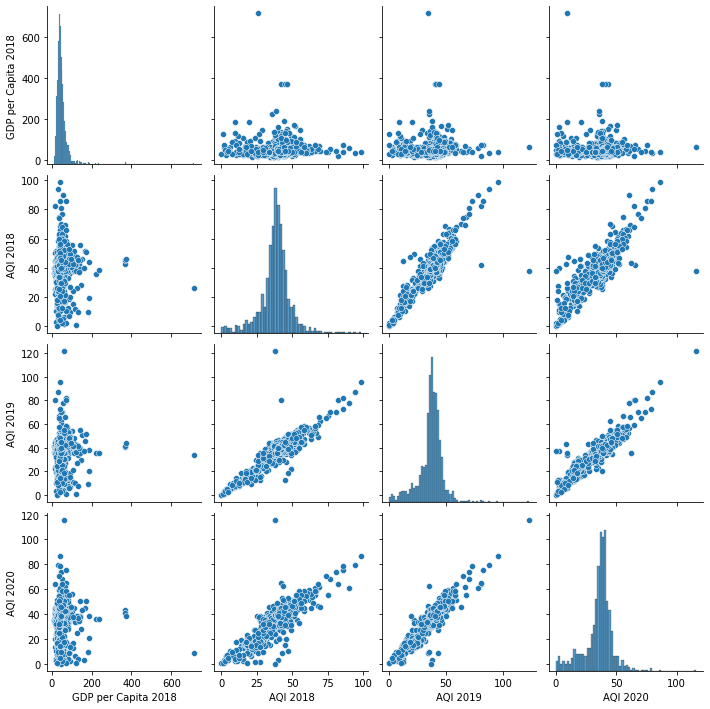

In [16]:
sns.pairplot(data = gdp_data)

Based on our findings, there is no immediate correlation that we can identify from the pairplot. However, that does not necessarily mean that there are no correlations present within the data. Further analysis on the data would have to be done to identify correlations within specific categories.

In [17]:
gdp_data.corr()

,GDP per Capita 2018,AQI 2018,AQI 2019,AQI 2020
GDP per Capita 2018,1.000000,0.043058,0.048077,0.001807
AQI 2018,0.043058,1.000000,0.896928,0.852532
AQI 2019,0.048077,0.896928,1.000000,0.920245
AQI 2020,0.001807,0.852532,0.920245,1.000000


The correlation matrix further shows that there is little correlation between <b>GDP per capita</b> and <b>AQI</b>. In order to better visualize the trend between these two variables, standardization of the data is required

We decided to take a closer look at one of our data points of interest which was the relationship between <mark>GDP per Capita</mark> and <mark>AQI 2018</mark>.

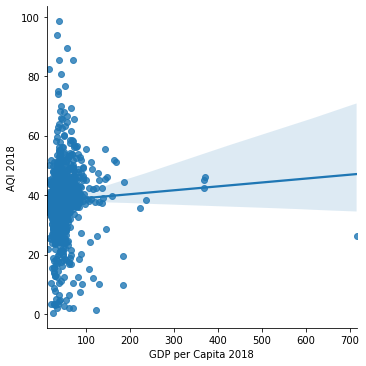

In [18]:
sns.lmplot(data=gdp_data, x="GDP per Capita 2018", y="AQI 2018")

Based on our EDA, we needed to take the log of our <mark>GDP per Capita 2018</mark> because the ranges of our data are too far apart from one another.  

In [19]:
gdp_data['Log GDP per Capita 2018'] = gdp_data['GDP per Capita 2018'].apply(lambda x: np.log(x))

We wanted to see if there are any correlations present within each year to see what the distribution looks like.

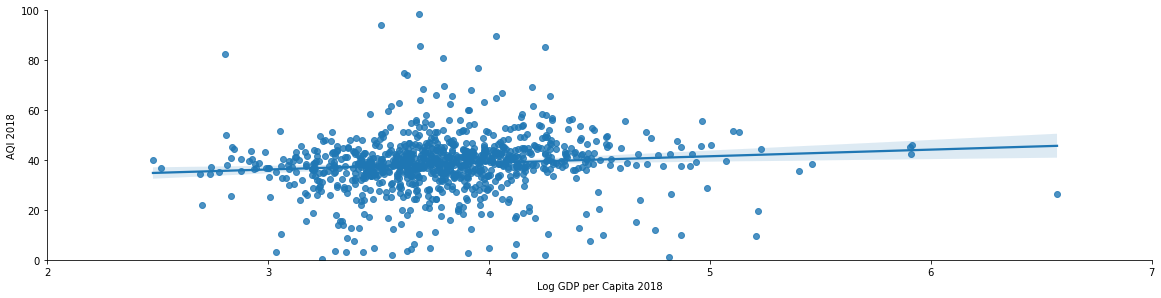

In [20]:
a_plot = sns.lmplot(data=gdp_data, x="Log GDP per Capita 2018", y="AQI 2018", height = 4, aspect = 4)

a_plot.set(xlim=(2, 7))
a_plot.set(ylim=(0, 100))

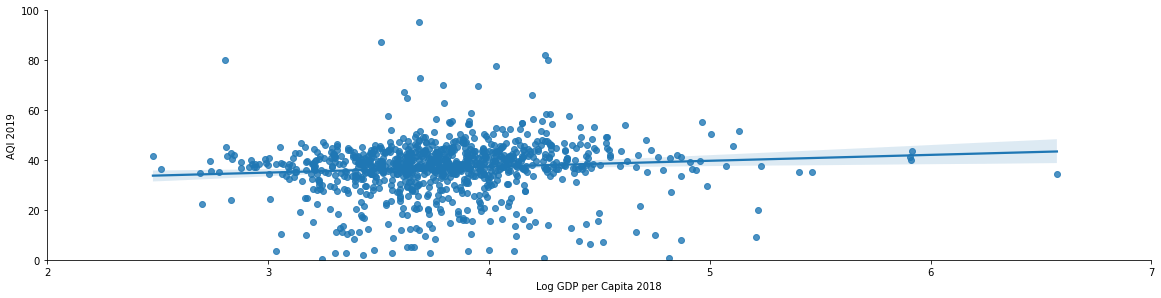

In [21]:
b_plot = sns.lmplot(data=gdp_data, x="Log GDP per Capita 2018", y="AQI 2019", height = 4, aspect = 4)

b_plot.set(xlim=(2, 7))
b_plot.set(ylim=(0, 100))

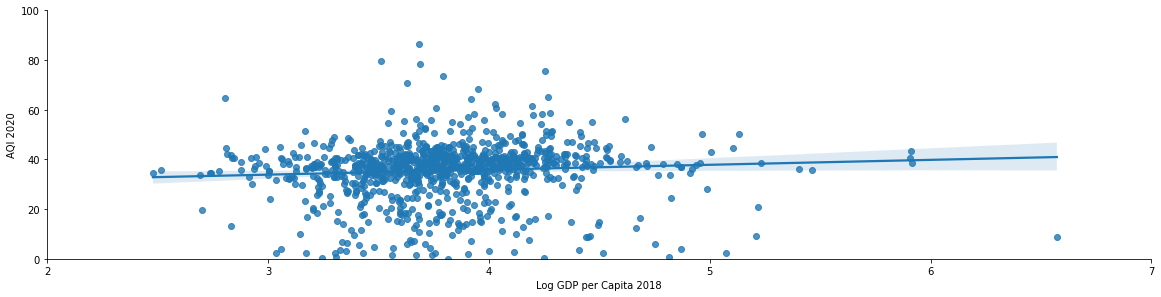

In [22]:
c_plot = sns.lmplot(data=gdp_data, x="Log GDP per Capita 2018", y="AQI 2020", height = 4, aspect = 4)

c_plot.set(xlim=(2, 7))
c_plot.set(ylim=(0, 100))

Splitting data of GDP per capita by percentiles would allow us to get a sense of whether or not there is a correlation betwen the GDP per capita and AQI for either high, medium or low income groups 

- high == 99th percentile
- medium == between 33rd and 66th percentile
- low == below 33rd percentile

In [23]:
highInc_AQI = gdp_data[gdp_data['GDP per Capita 2018'] <= gdp_data['GDP per Capita 2018'].quantile(.99)]
highInc_AQI = highInc_AQI[ highInc_AQI['GDP per Capita 2018'] >= highInc_AQI['GDP per Capita 2018'].quantile(.66)]

midInc_AQI = gdp_data[gdp_data['GDP per Capita 2018'] <= gdp_data['GDP per Capita 2018'].quantile(.66)]
midInc_AQI = midInc_AQI[midInc_AQI['GDP per Capita 2018'] >= midInc_AQI['GDP per Capita 2018'].quantile(.33)]

lowInc_AQI = gdp_data[gdp_data['GDP per Capita 2018'] <= gdp_data['GDP per Capita 2018'].quantile(.33)]  


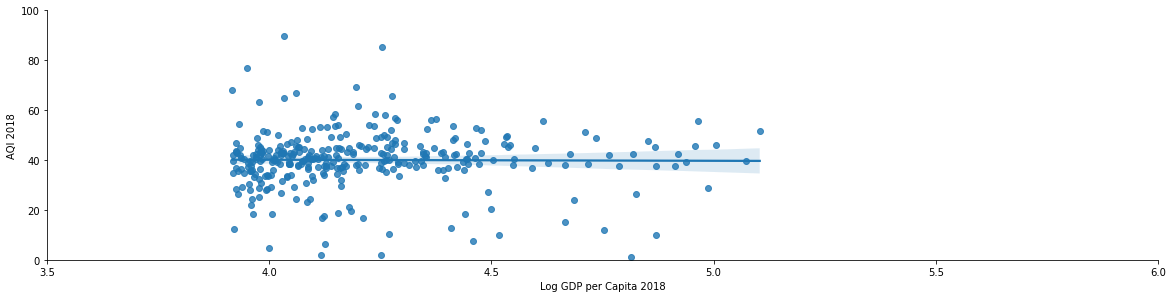

In [24]:
a_plot = sns.lmplot(data=highInc_AQI, x="Log GDP per Capita 2018", y="AQI 2018", height = 4, aspect = 4)

a_plot.set(xlim=(3.5, 6))
a_plot.set(ylim=(0, 100))

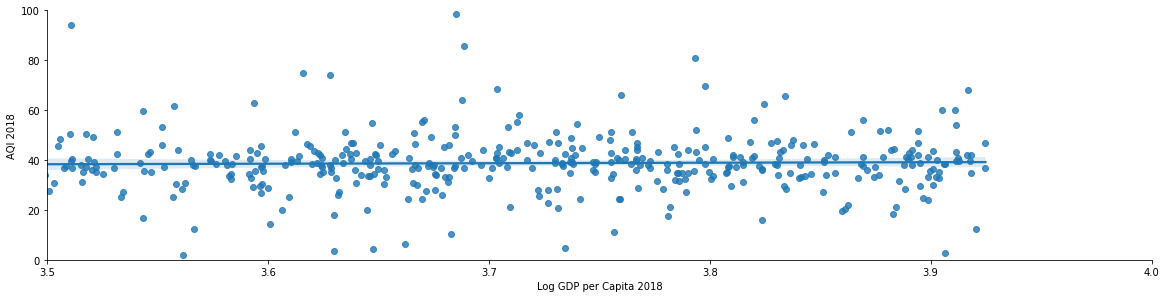

In [25]:
b_plot = sns.lmplot(data=midInc_AQI, x="Log GDP per Capita 2018", y="AQI 2018", height = 4, aspect = 4)

b_plot.set(xlim=(3.5, 4))
b_plot.set(ylim=(0, 100)) 

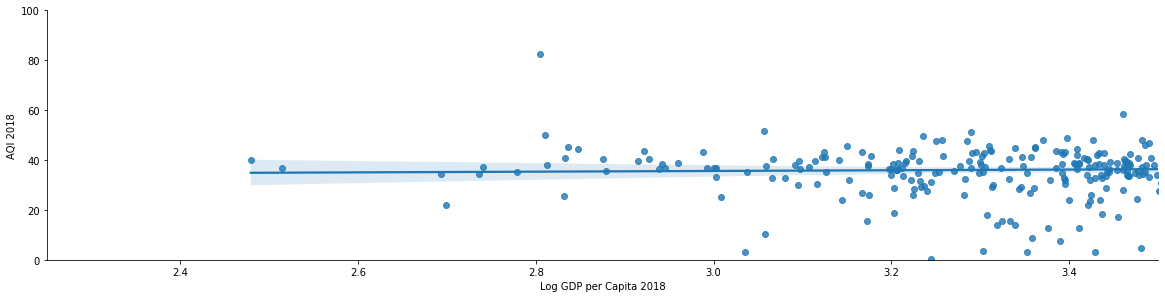

In [26]:
c_plot = sns.lmplot(data=lowInc_AQI, x="Log GDP per Capita 2018", y="AQI 2018", height = 4, aspect = 4)

c_plot.set(xlim=(2.25, 3.5))
c_plot.set(ylim=(0, 100))

From this we can see there is no real correlation between AQi and GDP per capita when in reference to income.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=38ab8c06-a79e-4579-8cac-68cea2b736bd' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>